In [1]:
import pickle as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm
from dfa import dfa
import scipy.signal as sig
from sklearn.linear_model import LogisticRegression
from scipy.interpolate import interp1d
from scipy.integrate import romb
plt.rcParams.update({'font.size': 22})
from hsl_functions import *
import glob
from scipy.signal import medfilt,butter

In [2]:
# Book-keeping Functions
n_splits = 10

def num_to_epoch(epoch_number):
    if epoch_number == 0:
        return 'UP1'
    elif epoch_number == 1:
        return 'UP2'
    elif epoch_number == 2:
        return 'P1'
    elif epoch_number == 3:
        return 'P2'
    elif epoch_number == 4:
        return 'REC'
    else:
        raise Exception('Invalid Epoch Number')

def num_to_subject(subject_number):
    return 'Subject'+str(subject_number)

def get_signal(measure, epoch, subjno):
    if isinstance(epoch,str):
        return np.ravel(df.loc[measure, epoch][num_to_subject(subjno)])
    elif isinstance(epoch, int):
        return np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)])

def get_split_signal(measure, epoch, subjno, splitno):
    if isinstance(epoch,str):
        return np.array_split(np.ravel(df.loc[measure, epoch][num_to_subject(subjno)]), n_splits)[splitno]
    elif isinstance(epoch, int):
        return np.array_split(np.ravel(df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)]),n_splits)[splitno]
    
def full_signal(measure, subjno):
    return np.concatenate((
        np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)]),
        np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)]),
    ))

def is_perturbed(epoch):
    if epoch == 0 or epoch == 1 or epoch == 4:
        return 0
    elif epoch == 2 or epoch == 3:
        return 1
    
def scaled_correlation_time(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(acorr)

def correlation_integral(signal1, signal2):
    signal1 = (signal1 - np.mean(signal1))/np.std(signal1)
    signal2 = (signal2 - np.mean(signal2))/np.std(signal2)
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    integral = np.trapz(acorr)
    return integral

def plot_full_experiment(measure, subjno):
    s1 = np.ravel(df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)])
    s2 = np.ravel(df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)])
    s3 = np.ravel(df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)])
    s4 = np.ravel(df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)])
    s5 = np.ravel(df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)])
    fullsignal = np.concatenate((s1,s2,s3,s4,s5))
    plt.plot(fullsignal,'k',label = measure)
    plt.axvline(x = len(s1), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3)+len(s4), color = 'k', linestyle = '--')
    plt.legend()

In [3]:
df = p.load(open('df.p','rb'))

all_subjects = np.concatenate((np.arange(11,25),np.arange(26,45)))

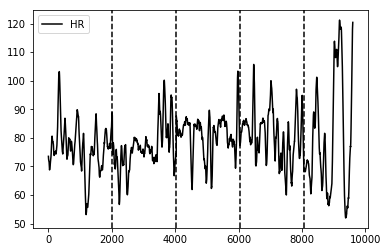

In [4]:
plot_full_experiment('HR', 24)

## Load Shimmer Data

In [5]:
shimfiles = glob.glob('shimmerData/*/*')

In [6]:
def get_shimmer(subjno, part, epochno):
    epoch = num_to_epoch(epochno)
    if epoch == 'REC':
        epoch = 'Rec'
    elif epoch == 'P1':
        epoch = '_P1'
    elif epoch == 'P2':
        epoch = '_P2'
    
    for file in shimfiles:
        if str(subjno) in file and part in file and epoch in file:
            data = pd.read_csv(file, header = None)
    try:
        vectors = np.asarray(data[[1,2,3]])
    except:
        print('mising shimmer data. skipping...')
        return np.repeat(np.nan, 1000)
    mean = np.mean(vectors, axis = 0)
    std = np.std(vectors, axis = 0)
    
    vectors = (vectors - mean[np.newaxis,:])

    #plt.plot(vectors)
    
    z_vector = np.linalg.norm(vectors, axis = 1)

    return z_vector

In [7]:
def get_split_shimmer(subjno, part, epochno, splitno):

    z_vector = get_shimmer(subjno,part,epochno)

    return np.array_split(z_vector,n_splits)[splitno]

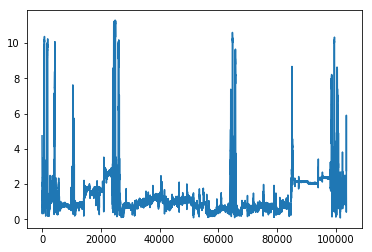

In [8]:
plt.plot(get_shimmer(12, 'body', 1))

## Get Features

In [9]:
import pywt

In [10]:
def signal_statistics(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    maximum = np.max(signal)
    minimum = np.min(signal)
    iqr = stats.iqr(signal)
    variation = stats.variation(signal)
    entropy = stats.entropy(np.abs(signal))
    corrtime = scaled_correlation_time(signal,signal)        
    return np.asarray([mean, std, skewness, kurtosis, maximum, minimum, iqr, variation, entropy, corrtime])

In [11]:
def spectrum_statistics(signal):
    
    fs,pxx = sig.periodogram(signal, fs = 50, nfft = 1000, scaling = 'density', detrend = 'constant')
    
#     plt.plot(fs,pxx)
    #plt.xlim(0,0.1)

    peak = fs[np.argmax(pxx)]
    peakmag = np.max(pxx)
    integral = np.trapz(pxx,fs)
    energy = np.dot(pxx,pxx)
    shannon = np.sum(pxx*np.log(1/pxx))

    # Add wavelet analysis

    return [peak, peakmag, integral, energy, shannon]

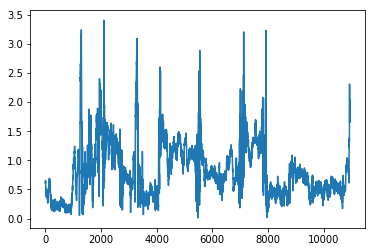

In [12]:
plt.plot(get_split_shimmer(32, 'body', 3, 2))

In [13]:
bfeatures = [];
n_splits = 50
targets = [];
allfeatures = []
hfeatures = [];

for subjno in tqdm(all_subjects[8:]):
    for epoch in range(4):
        for splitno in range(n_splits):
            
            bshim_signal = get_split_shimmer(subjno,'body',epoch,splitno)
            bfeature = np.concatenate((signal_statistics(bshim_signal), spectrum_statistics(bshim_signal)))
            bfeatures.append(bfeature)
            
            hshim_signal = get_split_shimmer(subjno,'head',epoch,splitno)
            hfeature = np.concatenate((signal_statistics(hshim_signal), spectrum_statistics(hshim_signal)))
            hfeatures.append(hfeature)

            targets.append(is_perturbed(epoch))

            allfeature = np.concatenate((bfeature,hfeature))
            allfeatures.append(allfeature)
        

allfeature_names = ['bodyshim_mean', 'bodyshim_std', 'bodyshim_skewness', 'bodyshim_kurtosis', \
                    'bodyshim_maximum', 'bodyshim_minimum', \
                            'bodyshim_iqr', 'bodyshim_variation', 'bodyshim_entropy', 'bodyshim_corrtime',\
                       'bodyshim_peakfreq','bodyshim_peakpower','bodyshim_powerint','bodyshim_specenergy',\
                   'bodyshim_shannon', \
                   'headshim_mean', 'headshim_std', 'headshim_skewness', 'headshim_kurtosis', \
                    'headshim_maximum', 'headshim_minimum', \
                            'headshim_iqr', 'headshim_variation', 'headshim_entropy', 'headshim_corrtime',\
                       'headshim_peakfreq','headshim_peakpower','headshim_powerint','headshim_specenergy',\
                   'headshim_shannon']
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

  0%|          | 0/25 [00:00<?, ?it/s]/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':
  4%|▍         | 1/25 [00:37<15:00, 37.54s/it]/Users/vedantchandra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in less


mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shi

  8%|▊         | 2/25 [00:55<12:07, 31.61s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shi

 12%|█▏        | 3/25 [01:14<10:14, 27.94s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...


 76%|███████▌  | 19/25 [11:22<04:06, 41.15s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shimmer data. skipping...
mising shi

 80%|████████  | 20/25 [11:52<03:08, 37.80s/it]

mising shimmer data. skipping...
mising shimmer data. skipping...


100%|██████████| 25/25 [15:47<00:00, 45.03s/it]


In [301]:
targets = np.asarray(targets)
fdf = pd.DataFrame(allfeatures, columns = allfeature_names)

In [15]:
from sklearn.feature_selection import mutual_info_classif
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

In [16]:
where = np.asarray(np.sum(np.isnan(fdf),1)) > 0

In [17]:
X = np.asarray(fdf.loc[~where])
t = np.asarray(targets)[~where]


sc = preprocessing.MinMaxScaler()
X_scaled = sc.fit_transform(X)

In [18]:
scores = mutual_info_classif(X_scaled,t)

Text(0.5, 1.0, 'Mutual Information Feature Selection')

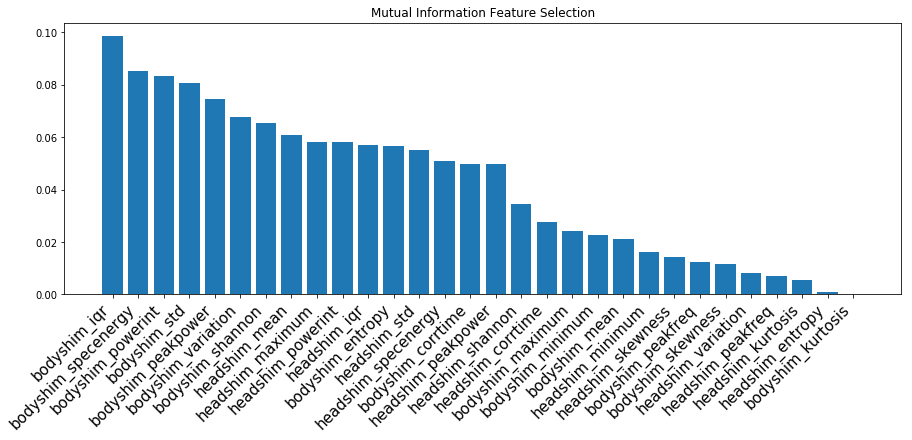

In [19]:
plt.figure(figsize=(15,5))
sortidx = np.argsort(-scores)
plt.bar(fdf.columns[sortidx],height=scores[sortidx],)
plt.xticks(rotation=45, ha='right',fontsize=15);
plt.title('Mutual Information Feature Selection')

0.7378694292084187


Text(0, 0.5, 'True Positive Rate')

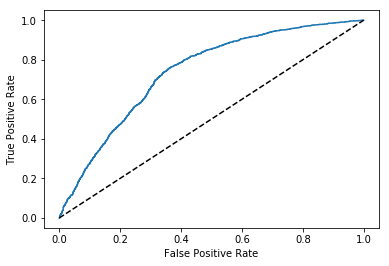

In [20]:
clf = LogisticRegression(solver = 'newton-cg', max_iter = 1000000, tol = 0.000001)

clf.fit(X_scaled,t)



lr_fpr,lr_tpr,_ = roc_curve(t,clf.predict_proba(X_scaled)[:,1])
print(auc(lr_fpr,lr_tpr))

plt.plot(lr_fpr,lr_tpr)
x = np.linspace(0,1,100)
plt.plot(x,x,'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')